In [1]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
from utils import data_ut as dut
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from models.SAmodel import MyNetwork
from models.Unrolled import Unrolled
from models.UnrolledRef import UnrolledRef
from models.UnrolledTransformer import UnrolledTrans

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

In [2]:
!pwd

/home/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [3]:
!which python3

/home/tal/docker/dockvenv/bin/python3


In [2]:
# Path to your NIfTI file
nii_file_target = './test_data/T1_week28reg.nii'
img_target = nib.load(nii_file_target)
nii_file_ref = './test_data/T1_week40regT1_week28.nii'
img_ref = nib.load(nii_file_ref)
target =  img_target.get_fdata()[...,25]
reference = img_ref.get_fdata()[...,25]

#Phase addition
random_phase = torch.angle(T.random_map((1,256,160), 'cpu',kspace_radius_range=(0.001, 0.001))) 
target = target * (torch.exp(1j * random_phase)).numpy() 
target = target.squeeze(0)
target_torch = cplx.to_tensor(target).float() 

# kspace transform
reference_torch = cplx.to_tensor(reference).float() 
reference_kspace_torch = T.fft2(reference_torch)
kspace_torch = T.fft2(target_torch)


# Resolution degrading
kspace_torch = T.kspace_cut(kspace_torch,0.67)
reference_kspace_torch = T.kspace_cut(reference_kspace_torch,0.67)
print(reference_kspace_torch.shape)
reference_torch = T.ifft2(reference_kspace_torch)
target_torch = T.ifft2(kspace_torch)
reference_kspace= cplx.to_numpy(reference_kspace_torch)
kspace = cplx.to_numpy(kspace_torch)

mask2 = sp.mri.poisson((172,108),2, calib=(18,14), dtype=float, crop_corner=False, return_density=True, seed=0, max_attempts=6, tol=0.01)
mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)

kspace_torch = T.awgn_torch(kspace_torch,15,L=1)

kspace_torch = kspace_torch*mask_torch



torch.Size([172, 108, 2])


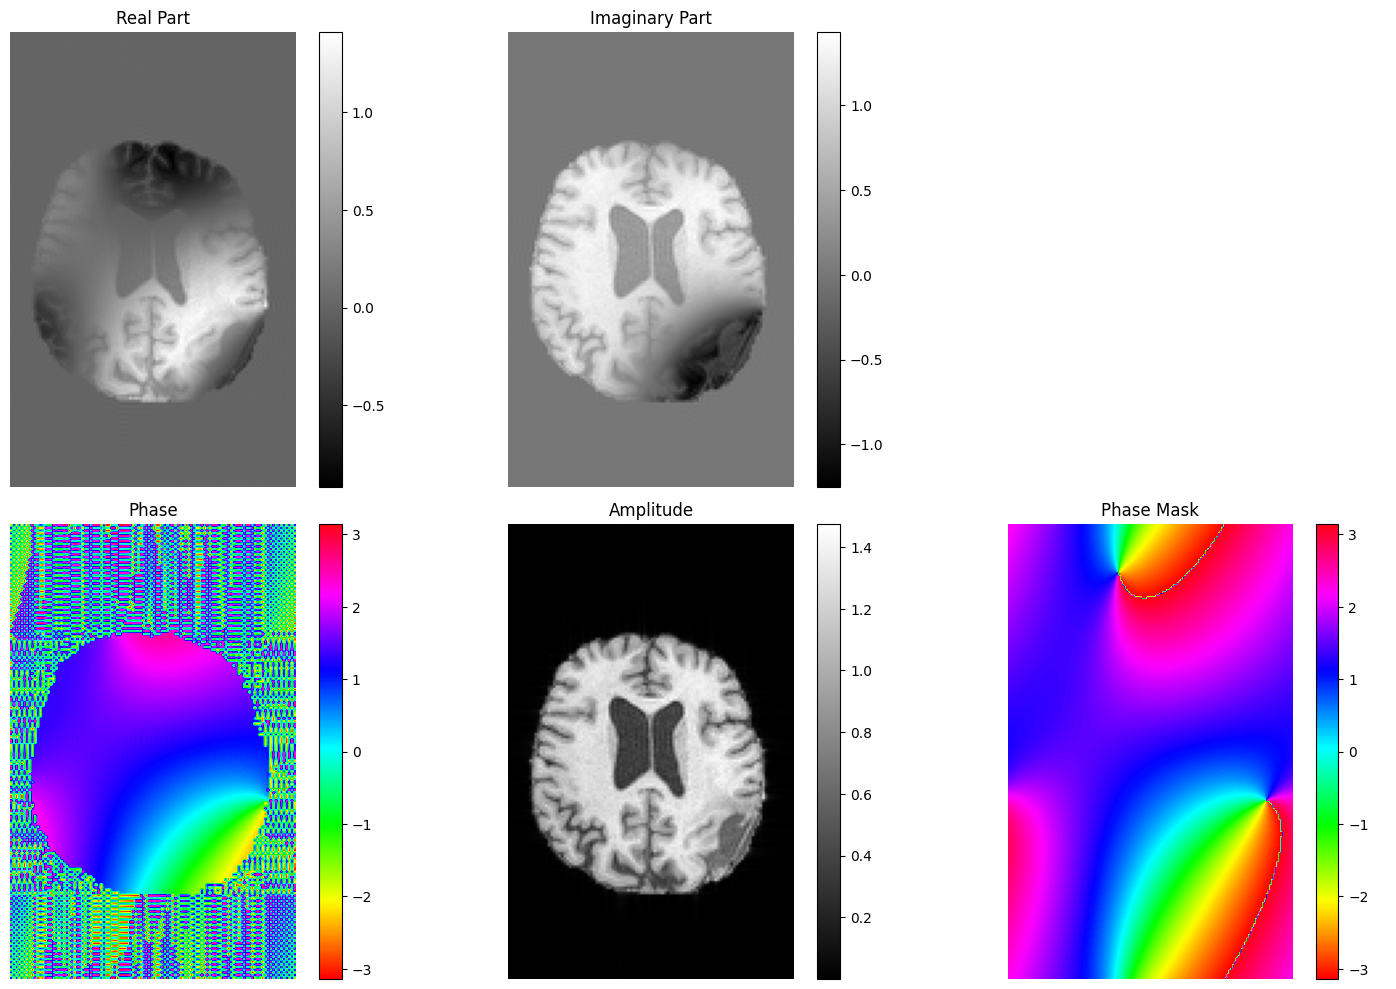

In [8]:
# Assuming 'image' is a complex-valued numpy array
image = cplx.to_numpy(target_torch)
phase_mask = np.angle((torch.exp(1j * random_phase)).numpy().squeeze(0) )

# Calculate real part, imaginary part, phase, and amplitude
real_part = np.real(image)
imaginary_part = np.imag(image)
phase = np.angle(image)
amplitude = np.abs(image)

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot real part
im_real = axs[0, 0].imshow(real_part, cmap='gray')
axs[0, 0].set_title('Real Part')
axs[0, 0].axis('off')
fig.colorbar(im_real, ax=axs[0, 0])

# Plot imaginary part
im_imag = axs[0, 1].imshow(imaginary_part, cmap='gray')
axs[0, 1].set_title('Imaginary Part')
axs[0, 1].axis('off')
fig.colorbar(im_imag, ax=axs[0, 1])

# Plot phase
im_phase = axs[1, 0].imshow(phase, cmap='hsv')
axs[1, 0].set_title('Phase')
axs[1, 0].axis('off')
fig.colorbar(im_phase, ax=axs[1, 0])

# Plot amplitude
im_amplitude = axs[1, 1].imshow(amplitude, cmap='gray')
axs[1, 1].set_title('Amplitude')
axs[1, 1].axis('off')
fig.colorbar(im_amplitude, ax=axs[1, 1])

# Plot phase mask
im_phase_mask = axs[1, 2].imshow(phase_mask, cmap='hsv')
axs[1, 2].set_title('Phase Mask')
axs[1, 2].axis('off')
fig.colorbar(im_phase_mask, ax=axs[1, 2])

# Hide the unused subplot
axs[0, 2].axis('off')

# Display the plots
plt.tight_layout()
plt.show()